## Setup evnironment

In [1]:
import os
import numpy as np
import pandas as pd
import json
from skimage.io import imread

In [2]:
from psf import compute, plotPSF

## Setup plotting

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_context('paper', font_scale=2.0)
sns.set_style('ticks')

In [4]:
from ipywidgets import interactive
from ipywidgets import IntSlider
from IPython.display import display

## Define parameters

In [5]:
# Full FOV
FOVpxLat = 2048.0 # 2048
UmPerPxLat = 1.6
pxPerUmLat = 1/UmPerPxLat
FOVumLat = FOVpxLat / pxPerUmLat
pxPerUmAx = 1.0 # 1.0
windowUm = [12, 10, 10]
options = {'FOVumLat':FOVumLat, 'FOVpxLat':FOVpxLat, 'pxPerUmLat':FOVpxLat/FOVumLat, 'pxPerUmAx':pxPerUmAx, 'windowUm':windowUm}
options['thresh'] = .05

In [ ]:
# 1/4 FOV
FOVpxLat = 512.0 # 2048
UmPerPxLat = 1.6
pxPerUmLat = 1/UmPerPxLat
FOVumLat = FOVpxLat / pxPerUmLat
pxPerUmAx = 1.0 # 1.0
windowUm = [20, 10, 10]
options = {'FOVumLat':FOVumLat, 'FOVpxLat':FOVpxLat, 'pxPerUmLat':FOVpxLat/FOVumLat, 'pxPerUmAx':pxPerUmAx, 'windowUm':windowUm}
options['thresh'] = .05

In [6]:
options

{'FOVpxLat': 2048.0,
 'FOVumLat': 3276.8,
 'pxPerUmAx': 1.0,
 'pxPerUmLat': 0.625,
 'thresh': 0.05,
 'windowUm': [12, 10, 10]}

## Get PSF

In [ ]:
im = imread('./data/images.tif', plugin='tifffile') # old testdata

In [ ]:
im = imread('./data/test2-noETL.tif', plugin='tifffile') # 512 px testdata

In [7]:
im = imread('./data/5ms_2nd_488_nm_508_520-35_4x_Right_000000-3-200slices.tif', plugin='tifffile')  # 2048 px testdata

In [21]:
im = imread('./data/5ms_2nd_noETL_488_nm_508_520-35_4x_Right_000000-2-200slices.tif', plugin='tifffile')  # 2048 px testdata

In [22]:
data, beads, maxima, centers, smoothed = compute(im, options)

In [23]:
PSF = pd.concat([x[0] for x in data])
PSF['Max'] = maxima
PSF = PSF.reset_index().drop(['index'],axis=1)
latProfile = [x[1] for x in data]
axProfile = [x[2] for x in data]

In [24]:
PSF

,FWHMlat,FWHMax,Max
0,2.700872,4.245531,12027
1,3.749820,10.539688,4113
2,2.716624,22.854434,2594
3,3.108246,14.232975,5126
4,2.915543,7.769087,4903
5,2.631363,3.520843,8068
6,3.928337,4.938880,6766
7,3.403806,17.645947,2036
8,2.435567,10.283529,1868
9,2.428726,9.553141,2448


In [25]:
print(len(PSF))
print(PSF.mean())
print(PSF.std())

614
FWHMlat       2.853855
FWHMax       42.691766
Max        4179.698697
dtype: float64
FWHMlat       0.453686
FWHMax      185.751315
Max        2721.936629
dtype: float64


## Plot max projection

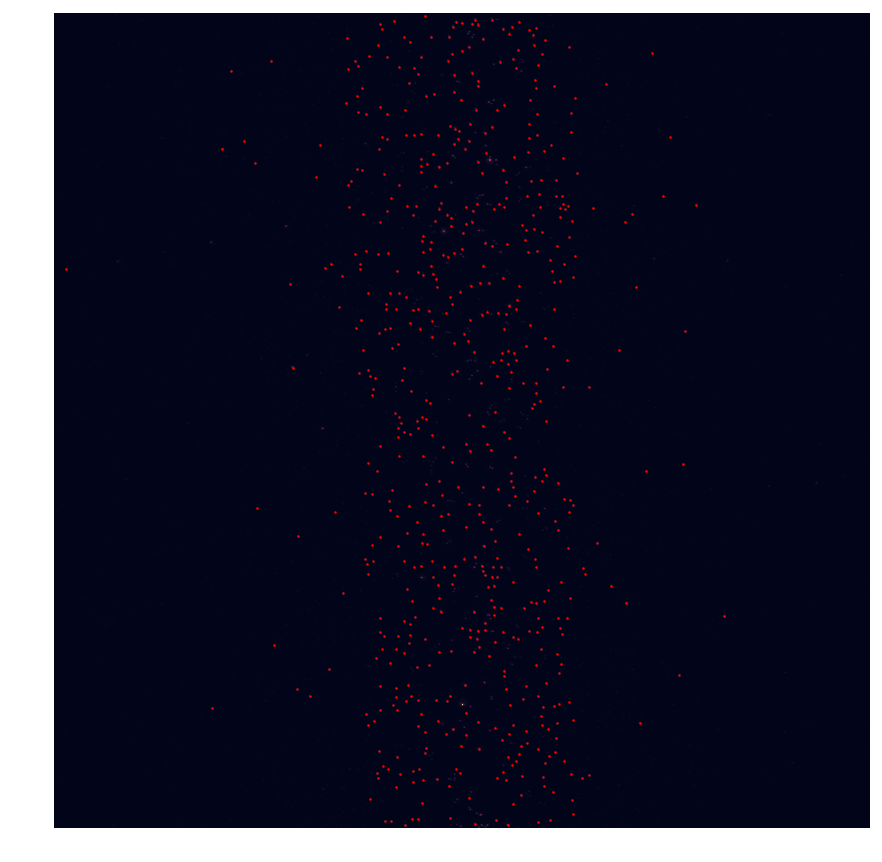

In [26]:
plt.figure(figsize=(15,15));
plt.imshow(smoothed);
plt.plot(centers[:, 2], centers[:, 1], 'r.', ms=5);
plt.xlim([0, smoothed.shape[0]])
plt.ylim([smoothed.shape[1], 0])
plt.axis('off');

In [ ]:
centers

In [ ]:
len(centers)

In [27]:
Ycenters = centers[:,1]
Xcenters = centers[:,2]

In [28]:
axPSF = PSF['FWHMax']

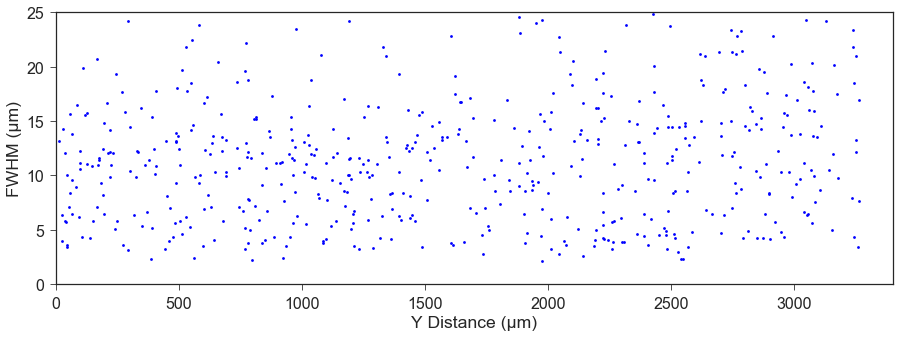

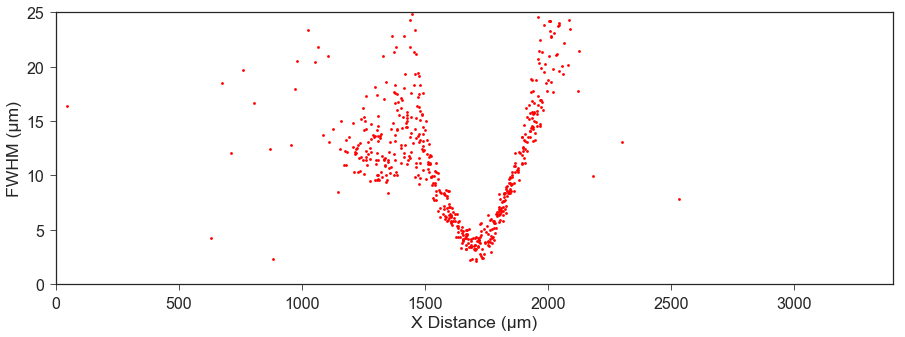

In [39]:
plt.figure(figsize=(15,5));
plt.plot(Ycenters*UmPerPxLat,axPSF,'.b')
plt.xlim([0,3400])
plt.ylim([0,25])
plt.xlabel('Y Distance (μm)')
plt.ylabel('FWHM (μm)')
plt.show()
plt.figure(figsize=(15,5));
plt.plot(Xcenters*UmPerPxLat,axPSF,'.r')
plt.xlim([0,3400])
plt.ylim([0,25])
plt.xlabel('X Distance (μm)')
plt.ylabel('FWHM (μm)')
plt.show()

In [ ]:
plt.figure(figsize=(15,5));
plt.plot(Ycenters,axPSF,'.b')
plt.ylim([0,25])
plt.show()
plt.figure(figsize=(15,5));
plt.plot(Xcenters,axPSF,'.r')
plt.ylim([0,25])
plt.show()


## Plot max projection

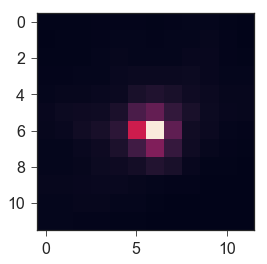

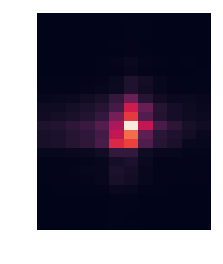

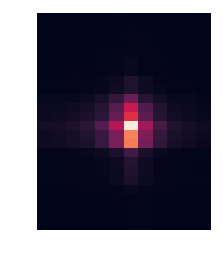

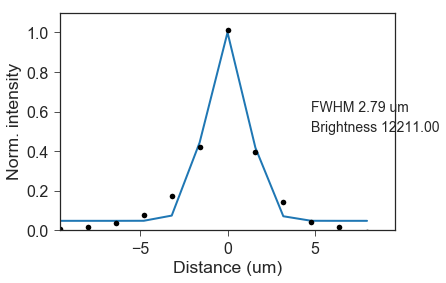

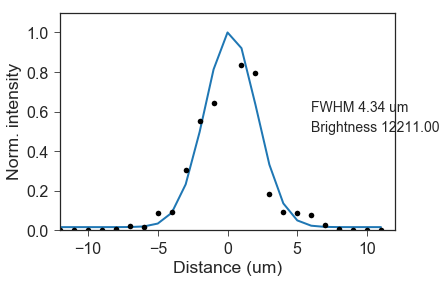

In [17]:
beadInd = 1359
average = beads[beadInd]
plt.imshow(average.mean(axis=0));
plt.axis('on');
plt.show()
plt.imshow(average.mean(axis=1), aspect = pxPerUmLat/pxPerUmAx);
plt.axis('off');
plt.show()
plt.imshow(average.mean(axis=2), aspect = pxPerUmLat/pxPerUmAx);
plt.axis('off');
plt.show()
plotPSF(latProfile[beadInd][0],latProfile[beadInd][1],latProfile[beadInd][2],latProfile[beadInd][3],pxPerUmLat,PSF.Max.iloc[beadInd])
plt.show()
plotPSF(axProfile[beadInd][0],axProfile[beadInd][1],axProfile[beadInd][2],axProfile[beadInd][3],pxPerUmAx,PSF.Max.iloc[beadInd])
plt.show()